Parameters:

In [2]:
p = 0.95 
scale = 56

Custom functions:

In [3]:
def wrd_div(n, d):
    return n / d if d else 0

def est_coef(x, y): 
    
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 

    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 

    k = SS_xy / SS_xx 
    b = m_y - k*m_x 
  
    return(b, k)

def power_func(x, a, b):
    return a*np.power(np.array(x), b)

def parab_func(x, a, b, c, d, e):
    return a/np.sqrt(np.power(np.array(x), b)+c*np.array(x)+d)

Import libraries:

In [4]:
from scipy.optimize import curve_fit
from statistics import median
import statsmodels.api as sm

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.dates as dates
from sklearn import preprocessing
import statsmodels.api as sm

Ignore warnings:

In [5]:
warnings.filterwarnings('ignore')

Read data:

In [6]:
df = pd.ExcelFile('data/data.xlsx').parse('data')
label = ['TLT', 'SPY', 'GOLD', 'REIT']

Format data:

In [7]:
df = df.dropna(how='any', axis=0)
df['DATE'] =  pd.to_datetime(df['DATE']).dt.date

Show time period and records number:

In [8]:
print('Dates:', list(df['DATE'])[0], 'to', list(df['DATE'])[-1])
print('Number of records:', len(df))

Dates: 2004-11-15 to 2019-11-08
Number of records: 783


Drop date feature:

In [9]:
df = df.drop(['DATE'], axis=1) 

Metrics vice horizon:

In [10]:
df_stat, df_hor = [],[]
p_med, p_std, p_var = [], [], []

for i in range(2*scale): 
    
    df_hor.append(i/scale)
    
    df_ret = 100*df.apply(np.log).diff(periods=i)
    p_ret = (1/len(df_ret.columns))*df_ret.sum(axis = 1, skipna = True)
    
    df_med = df_ret.apply(lambda x : x.median())
    df_std = df_ret.apply(lambda x : x.std())
    df_var = df_ret[df_ret <= 0].apply(lambda x : x.abs().quantile(p))
    
    p_med.append(p_ret.median())
    p_std.append(p_ret.std())
    p_var.append(np.quantile(([abs(x) for x in p_ret if x <= 0]), p))
    
    df_stat.append(pd.DataFrame({'Return': df_med, 'Standard': df_std, 'Value at risk': df_var}))

Define statistics:

In [11]:
ass_ret,ass_std,ass_var = [],[],[]

for item in range(4):
    
    ass_ret.append(list([float(df_stat[x]['Return'].iloc[item]) for x in range(2*scale)]))
    ass_std.append(list([float(df_stat[x]['Standard'].iloc[item]) for x in range(2*scale)]))
    ass_var.append(list([float(df_stat[x]['Value at risk'].iloc[item]) for x in range(2*scale)]))

Sharpe ratio for SPY and 1/N:

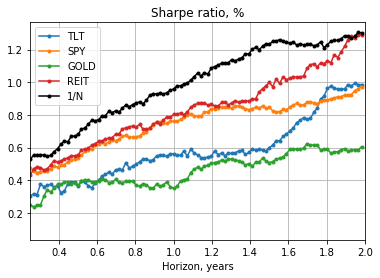

In [12]:
for i in range(4): 
    z = [wrd_div(x,y) for x, y in zip(ass_ret[i], ass_std[i])][1:] 
    plt.plot(df_hor[1:], z, '.-', label=label[i])

plt.plot(df_hor[1:], [wrd_div(x,y) for x, y in zip(p_med, p_std)][1:], '.-', label='1/N', color='black') 
   
plt.title('Sharpe ratio, %')
plt.xlabel('Horizon, years')
plt.legend(loc='upper left')

plt.xlim(0.25,2)

plt.grid(True)
plt.show()

Median return vice horizon:

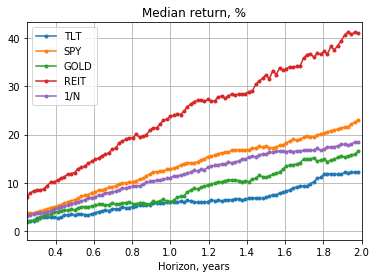

In [13]:
for i in range(4):
    plt.plot(df_hor[1:], ass_ret[i][1:], '.-', label=label[i])

plt.plot(df_hor[1:], p_med[1:], '.-', label='1/N')
plt.title('Median return, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.xlim(0.25,2)
plt.grid(True)

plt.show()

Value at risk (95%) vice horizon:

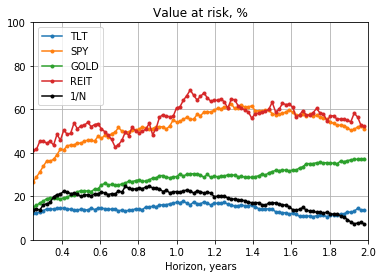

In [14]:
for i in range(4):
    plt.plot(df_hor[1:], ass_var[i][1:], '.-', label=label[i])

plt.plot(df_hor[1:], p_var[1:], '.-', label='1/N', color='black')

plt.title('Value at risk, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.ylim(0,100)
plt.xlim(0.25,2)

plt.show()

Return/Var for assets:

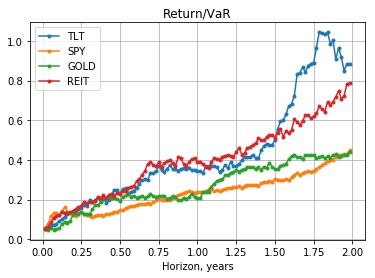

In [15]:
for i in range(4):
    
    z = [wrd_div(x,y) for x, y in zip(ass_ret[i][1:], ass_var[i][1:])]
    plt.plot(df_hor[1:], z, '.-', label=label[i])

plt.title('Return/VaR')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Return/Var for 1/N portfolio:

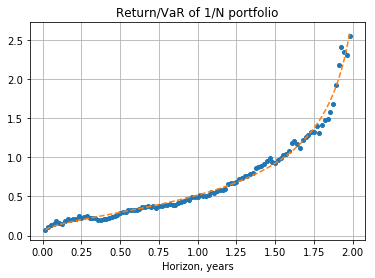

In [16]:
t = [wrd_div(x,y) for x, y in zip(p_med[1:], p_var[1:])] 
plt.plot(df_hor[1:], t, '.', markersize=8)

popt, pcov = curve_fit(parab_func, df_hor[1:], t)
plt.plot(df_hor[1:], parab_func(df_hor[1:], *popt), '--')

plt.title('Return/VaR of 1/N portfolio')
plt.xlabel('Horizon, years')
plt.grid(True)

plt.show()

Metrics of 1/N portfolio without rebalancing:

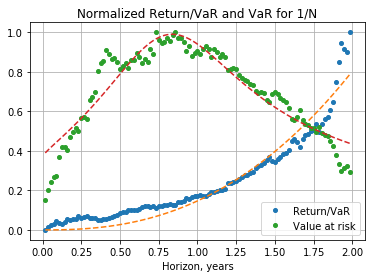

In [17]:
z = [wrd_div(x,y) for x, y in zip(p_med, p_var)][1:] 
z = (z - min(z))/(max(z)-min(z))

t = (p_var - min(p_var))/(max(p_var)-min(p_var)) 

plt.plot(df_hor[1:], z, '.', label='Return/VaR', markersize=8)
popt, pcov = curve_fit(power_func, df_hor[1:], z)
plt.plot(df_hor[1:], power_func(df_hor[1:], *popt), '--')

plt.plot(df_hor[1:], t[1:], '.', label='Value at risk', markersize=8)
popt, pcov = curve_fit(parab_func, df_hor[1:], t[1:])
plt.plot(df_hor[1:], parab_func(df_hor[1:], *popt), '--')

plt.title('Normalized Return/VaR and VaR for 1/N')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Cumulated return of rebalanced portfolio:

In [18]:
p_cum, p_hor = [], []

for i in range(1, 2*scale):
    
    df_p = df.iloc[::i].apply(np.log).diff(periods=1).dropna(axis = 0)
    df_p = 0.25*df_p.sum(axis=1)
    df_p = 100*(df_p+1).product()-1
    
    p_hor.append(i/scale)
    p_cum.append(df_p)

Number of years:

In [19]:
print('Number of years:', int(round(len(df)/scale)))

Number of years: 14


Plot cumulated return vice holding period:

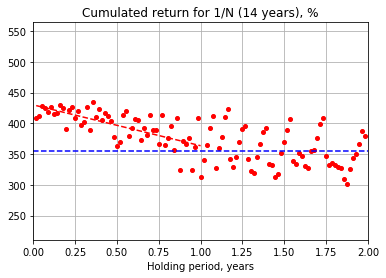

In [22]:
plt.plot(p_hor[:scale], p_cum[:scale], '.', markersize=8, color='red')
x,y = np.unique(p_hor[:scale]), np.poly1d(np.polyfit(p_hor[:scale], p_cum[:scale], 1))
plt.plot(x, y(x), '--', color='red')

plt.plot(p_hor[scale:], p_cum[scale:], '.', markersize=8, color='red')
plt.axhline(y=np.mean(p_cum[scale:]), linestyle='--', color='blue')

plt.ylim(0.7*min(p_cum), 1.3*max(p_cum))
plt.xlabel('Holding period, years')
plt.title('Cumulated return for 1/N (14 years), %')

plt.xlim(0,2)
plt.grid(True)
plt.show()

Show statistics of linear regression:

In [21]:
model = sm.OLS(p_hor, p_cum).fit()
reg_stat = model.summary().tables[0]
print(reg_stat)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     248.0
Date:                Fri, 10 Jan 2020   Prob (F-statistic):           5.93e-30
Time:                        21:42:52   Log-Likelihood:                -107.73
No. Observations:                 111   AIC:                             217.5
Df Residuals:                     110   BIC:                             220.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
